# PCA 

The goal of the project is to use a dimension reduction approach (PCA, etc.) to decompose and transform high-dimension image data into a (much) lower dimension space for classification and clustering. The dataset can be found here: https://drive.google.com/drive/folders/1FcSHxEKHIyZ_Vckh6K1GDTN-VdM7tgD6 

For each subtask listed below, find the best two eigenvectors that define a 2D space to best separate corresponding categories, visualize individual data points in a 2D plot and calculate a Silhouette score
for each subtask. <br>

Subtask 1. Emotion recognition <br>
Subtask 2. Mask detection <br>
Subtask 3. Person identification <br>

Bonus points: Instead of using a whole image, you are encouraged to try other (creative) ways to solve each problem. A better solution should have a higher Silhouette score than the default one. Even if you may not be able to implement an idea you come up with, you will earn extra points by clearly describing a new idea and explaining in what ways it may improve performance. <br>

Write a report to explain your results and summarize what you’ve learned by trying to find the best dimension reduction solution for each problem.

# Contents
[Method 1: Grayscale image](#method1) <br>
[Method 2: Edges](#method2) <br>
[Method 3: Crop Image](#method3) <br>


# Load data

In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

results = pd.DataFrame()

In [2]:
data_dir = '/Users/mcmahonmc/Github/machine-learning-2021/02_pca/processed/'

img_files = sorted(glob.glob(data_dir + '*.jpg'))
print('We have %.f images total' % len(img_files))

We have 112 images total


In [3]:
data = pd.DataFrame({'person': [file.split('processed/')[1].split('_')[0] for file in img_files],
                     'emotion': [file.split('processed/')[1].split('_')[1] for file in img_files],
                     'mask': [file.split('processed/')[1].split('_')[2].split('.jpg')[0] for file in img_files]})

data['emotion'] = data['emotion'].replace(['A', 'H', 'N', 'S'], ['Angry', 'Happy', 'Neutral', 'Sad'])
data['mask'] = data['mask'].replace(['M', 'N'], ['Mask', 'No Mask'])

data

person  emotion     mask
0      AMR    Angry     Mask
1      AMR    Angry  No Mask
2      AMR    Happy     Mask
3      AMR    Happy  No Mask
4      AMR  Neutral     Mask
..     ...      ...      ...
107     ZM    Happy  No Mask
108     ZM  Neutral     Mask
109     ZM  Neutral  No Mask
110     ZM      Sad     Mask
111     ZM      Sad  No Mask

[112 rows x 3 columns]

(265, 200)


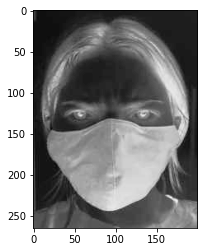

In [4]:
img0 = cv2.imread(img_files[0], cv2.IMREAD_GRAYSCALE)
print(img0.shape)
plt.imshow(img0, cmap='Greys')

In [5]:
images = np.zeros((265,200))

for img_file in img_files:
    images = np.dstack((images, cv2.imread(img_file ,cv2.IMREAD_GRAYSCALE)))

images = images[:,:,1:]
images = np.transpose(images, (2, 0, 1))
n_samples, h, w = images.shape
print(images.shape)                

(112, 265, 200)


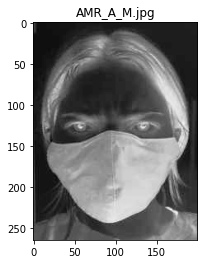

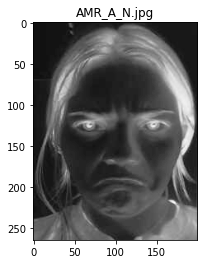

In [6]:
plt.imshow(images[0], cmap='Greys')
plt.title(img_files[0].split('processed/')[1])
plt.show()

plt.imshow(images[1], cmap='Greys')
plt.title(img_files[1].split('processed/')[1])
plt.show()

In [7]:
X = images.reshape((112,-1))
n_features = X.shape[1]

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Method 1: Grayscale Image <a id='method1'></a>

## Subtask 1. Emotion recognition

In [9]:
y = data['emotion']
target_names = np.unique(y)
n_classes = target_names.shape[0]

# Print Details about dataset
print("Number of Data Samples: % d" % n_samples)
print("Size of a data sample: % d" % n_features)
print("Number of Class Labels: % d" % n_classes)


Number of Data Samples:  112
Size of a data sample:  53000
Number of Class Labels:  4


In [10]:
def plot_gallery(images, titles, h, w, n_samples=images.shape[0], n_col = 4):
    n_row = math.ceil(n_samples/n_col)
    plt.figure(figsize =(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom = 0, left =.01, right =.99, top =1, hspace =.55)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap = plt.cm.gray)
        plt.title(str(titles[i]).replace(' ', '\n'), size = 10)
        plt.xticks(()); plt.yticks(())


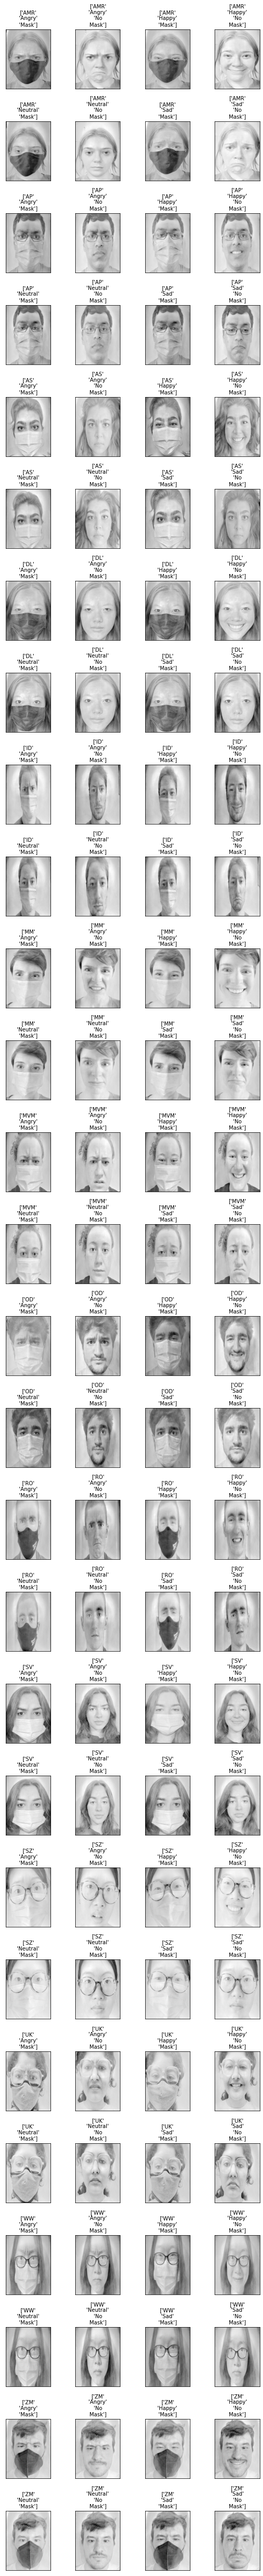

In [11]:
titles = np.array(data)

plot_gallery(X, titles, h, w)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

print("size of training Data is % d and Testing Data is % d" %(y_train.shape[0], y_test.shape[0]))



size of training Data is  84 and Testing Data is  28


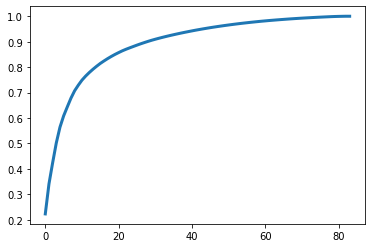

In [13]:
pca = PCA().fit(X_train)

plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3)

In [14]:
np.where([pca.explained_variance_ratio_.cumsum() > .80])[1][0]

14

In [15]:
# n_components = 14
n_components = 10

pca = PCA(n_components = n_components, svd_solver ='randomized', whiten = True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


Projecting the input data on the eigenfaces orthonormal basis


In [16]:
classifer = SVC().fit(X_train_pca, y_train)

predictions = classifer.predict(X_test_pca)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       Angry       0.18      0.50      0.26         6
       Happy       0.00      0.00      0.00         8
     Neutral       0.00      0.00      0.00         8
         Sad       0.00      0.00      0.00         6

    accuracy                           0.11        28
   macro avg       0.04      0.12      0.07        28
weighted avg       0.04      0.11      0.06        28



In [17]:
X_test.shape[0]-1

27

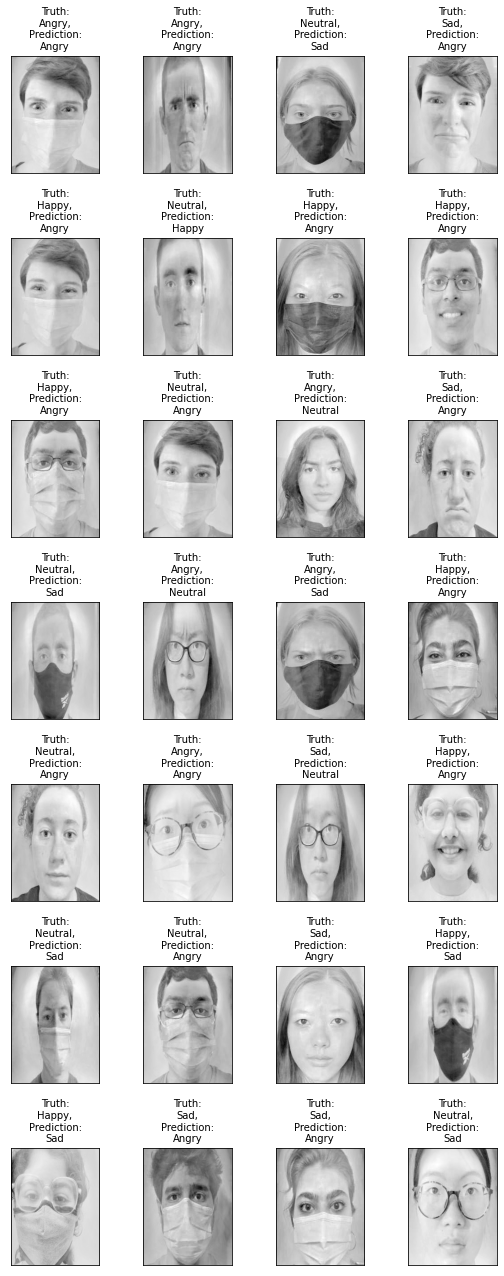

In [18]:
titles = ['Truth: %s, Prediction: %s' % (y_test_, predictions_) for y_test_, predictions_ in zip(y_test, predictions)]

plot_gallery(X_test, titles, h, w, n_samples=X_test.shape[0]-1)

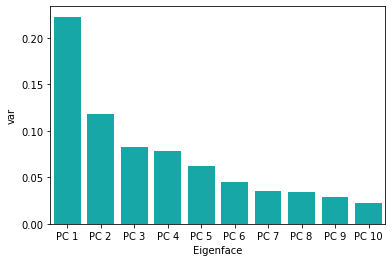

In [19]:
df = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'Eigenface': ['PC ' + str(i+1) for i in range(0, len(eigenfaces))]})

sns.barplot(x='Eigenface',y="var", data=df, color="c");

In [20]:
pc_df = pd.DataFrame(data = X_test_pca , 
        columns = ['Eigen ' + str(i+1) for i in range(0, len(eigenfaces))])
pc_df['Cluster'] = y
pc_df.head()

Eigen 1   Eigen 2   Eigen 3   Eigen 4   Eigen 5   Eigen 6   Eigen 7  \
0 -0.197991  0.731568 -0.086852  1.982622 -0.850612 -0.055696  1.037691   
1 -0.572764  0.494469 -0.576119 -1.034152  0.343046 -1.458466  0.337312   
2 -0.820833 -1.839789  1.660365 -1.297846 -0.775268  0.204787  0.755586   
3 -0.340118  0.450103 -1.037794  1.311257 -0.451065  0.012166 -0.594413   
4 -0.196241  0.522305 -0.184070  1.814330 -0.649030 -0.269990  1.294687   

    Eigen 8   Eigen 9  Eigen 10  Cluster  
0 -0.782860  0.252170 -0.516752    Angry  
1  0.655050 -0.054635 -1.026593    Angry  
2 -0.063127 -0.011699  1.551442    Happy  
3 -0.072297  0.337314 -0.897347    Happy  
4 -0.817797 -0.109712 -0.575266  Neutral

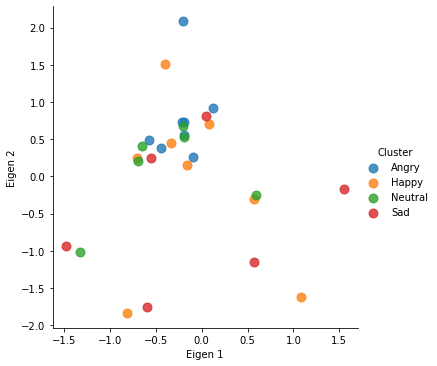

In [21]:
sns.lmplot( x="Eigen 1", y="Eigen 2",
  data=pc_df, 
  fit_reg=False, 
  hue='Cluster', # color by cluster
  legend=True,
  scatter_kws={"s": 80}) # specify the point size

In [22]:
results = results.append({'subtask': 'emotion', 
                          'method': '1-raw', 
                          'silhouette_score': metrics.silhouette_score(X_train, y_train)}, ignore_index=True)

print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_train, y_train))

Silhouette Coefficient: -0.037


## Subtask 2. Mask recognition

In [23]:
y = data['mask']
target_names = np.unique(y)
n_classes = target_names.shape[0]

# Print Details about dataset
print("Number of Data Samples: % d" % n_samples)
print("Size of a data sample: % d" % n_features)
print("Number of Class Labels: % d" % n_classes)

Number of Data Samples:  112
Size of a data sample:  53000
Number of Class Labels:  2


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

print("size of training Data is % d and Testing Data is % d" %(y_train.shape[0], y_test.shape[0]))

size of training Data is  84 and Testing Data is  28


In [25]:
pca = PCA().fit(X_train)

# n_components = np.where([pca.explained_variance_ratio_.cumsum() > .80])[1][0]
n_components = 10
print('Number of components: %s' % n_components)

pca = PCA(n_components = n_components, svd_solver ='randomized', whiten = True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


Number of components: 10
Projecting the input data on the eigenfaces orthonormal basis


In [26]:
classifer = SVC().fit(X_train_pca, y_train)

predictions = classifer.predict(X_test_pca)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

        Mask       0.85      0.69      0.76        16
     No Mask       0.67      0.83      0.74        12

    accuracy                           0.75        28
   macro avg       0.76      0.76      0.75        28
weighted avg       0.77      0.75      0.75        28



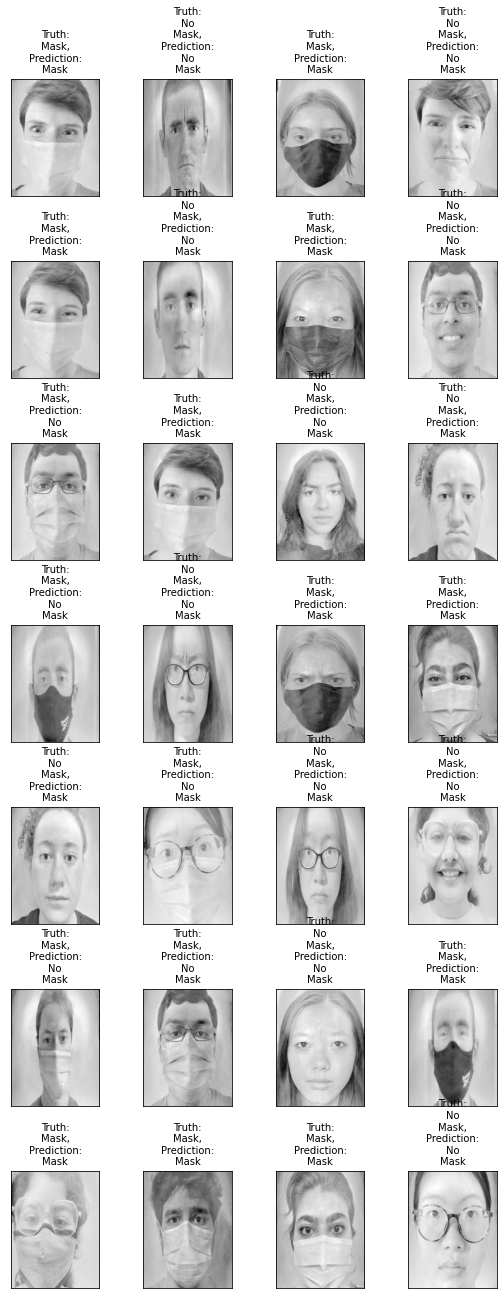

In [27]:
titles = ['Truth: %s, Prediction: %s' % (y_test_, predictions_) for y_test_, predictions_ in zip(y_test, predictions)]

plot_gallery(X_test, titles, h, w, n_samples=X_test.shape[0]-1)

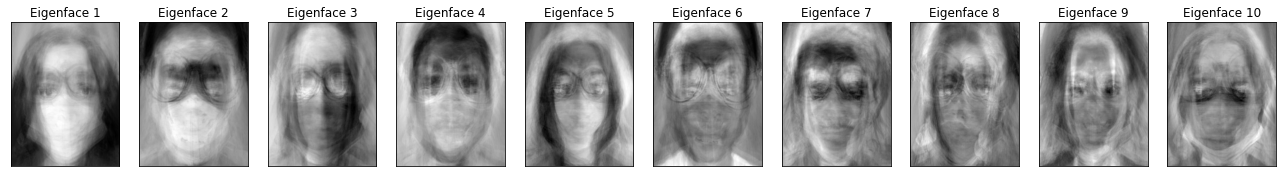

In [28]:
i=0
n_row = 1
n_col = len(eigenfaces)
plt.figure(figsize =(1.8 * n_col, 2.4 * n_row))
for eigenface in eigenfaces:
    plt.subplot(n_row, n_col, i+1)
    plt.imshow(eigenface.reshape((h,w)), cmap = plt.cm.gray)
    plt.title('Eigenface %s' % str(i+1))
    plt.xticks(()); plt.yticks(())
    i +=1

plt.tight_layout()

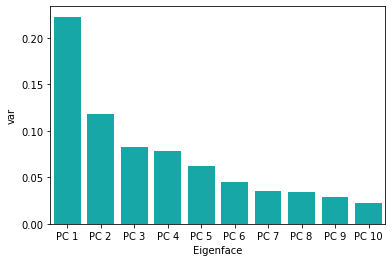

In [29]:
df = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'Eigenface': ['PC ' + str(i+1) for i in range(0, len(eigenfaces))]})

sns.barplot(x='Eigenface',y="var", data=df, color="c");

In [30]:
pc_df = pd.DataFrame(data = X_test_pca , 
        columns = ['Eigen ' + str(i+1) for i in range(0, len(eigenfaces))])
pc_df['Cluster'] = y
pc_df.head()

Eigen 1   Eigen 2   Eigen 3   Eigen 4   Eigen 5   Eigen 6   Eigen 7  \
0 -0.197991  0.731567 -0.086853  1.982627 -0.850621 -0.055885  1.037958   
1 -0.572764  0.494469 -0.576117 -1.034148  0.343031 -1.458550  0.337061   
2 -0.820833 -1.839789  1.660364 -1.297839 -0.775278  0.204462  0.755410   
3 -0.340118  0.450104 -1.037794  1.311265 -0.451080  0.012216 -0.594236   
4 -0.196241  0.522304 -0.184070  1.814333 -0.649048 -0.270088  1.294927   

    Eigen 8   Eigen 9  Eigen 10  Cluster  
0 -0.782662  0.252409 -0.512364     Mask  
1  0.655357 -0.054407 -1.030325  No Mask  
2 -0.062949 -0.010765  1.549626     Mask  
3 -0.072366  0.339110 -0.903536  No Mask  
4 -0.817428 -0.109443 -0.567607     Mask

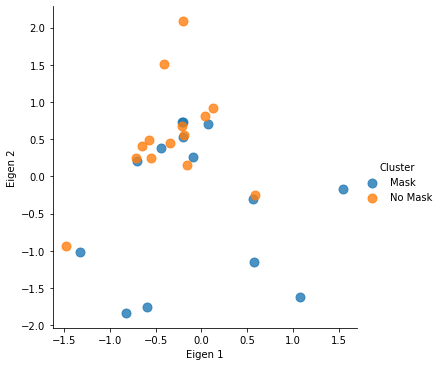

In [31]:
sns.lmplot( x="Eigen 1", y="Eigen 2",
  data=pc_df, 
  fit_reg=False, 
  hue='Cluster', # color by cluster
  legend=True,
  scatter_kws={"s": 80}) # specify the point size

In [32]:
results = results.append({'subtask': 'mask', 
                          'method': '1-raw', 
                          'silhouette_score': metrics.silhouette_score(X_train, y_train)}, ignore_index=True)

print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_train, y_train))

Silhouette Coefficient: 0.006


## Subtask 3. Person recognition

In [33]:
y = data['person']
target_names = np.unique(y)
n_classes = target_names.shape[0]

# Print Details about dataset
print("Number of Data Samples: % d" % n_samples)
print("Size of a data sample: % d" % n_features)
print("Number of Class Labels: % d" % n_classes)

Number of Data Samples:  112
Size of a data sample:  53000
Number of Class Labels:  14


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

print("size of training Data is % d and Testing Data is % d" %(y_train.shape[0], y_test.shape[0]))



size of training Data is  84 and Testing Data is  28


In [35]:
pca = PCA().fit(X_train)

# n_components = np.where([pca.explained_variance_ratio_.cumsum() > .80])[1][0] 
n_components = 10
print('Number of components: %s' % n_components)

pca = PCA(n_components = n_components, svd_solver ='randomized', whiten = True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


Number of components: 10
Projecting the input data on the eigenfaces orthonormal basis


In [36]:
classifer = SVC().fit(X_train_pca, y_train)

predictions = classifer.predict(X_test_pca)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         AMR       1.00      1.00      1.00         2
          AP       1.00      1.00      1.00         3
          AS       0.00      0.00      0.00         2
          DL       1.00      1.00      1.00         2
          ID       1.00      1.00      1.00         1
          MM       1.00      0.25      0.40         4
         MVM       0.67      1.00      0.80         2
          OD       0.25      1.00      0.40         1
          RO       0.80      1.00      0.89         4
          SV       1.00      1.00      1.00         1
          SZ       1.00      1.00      1.00         2
          UK       1.00      1.00      1.00         2
          WW       1.00      1.00      1.00         2

    accuracy                           0.82        28
   macro avg       0.82      0.87      0.81        28
weighted avg       0.85      0.82      0.79        28



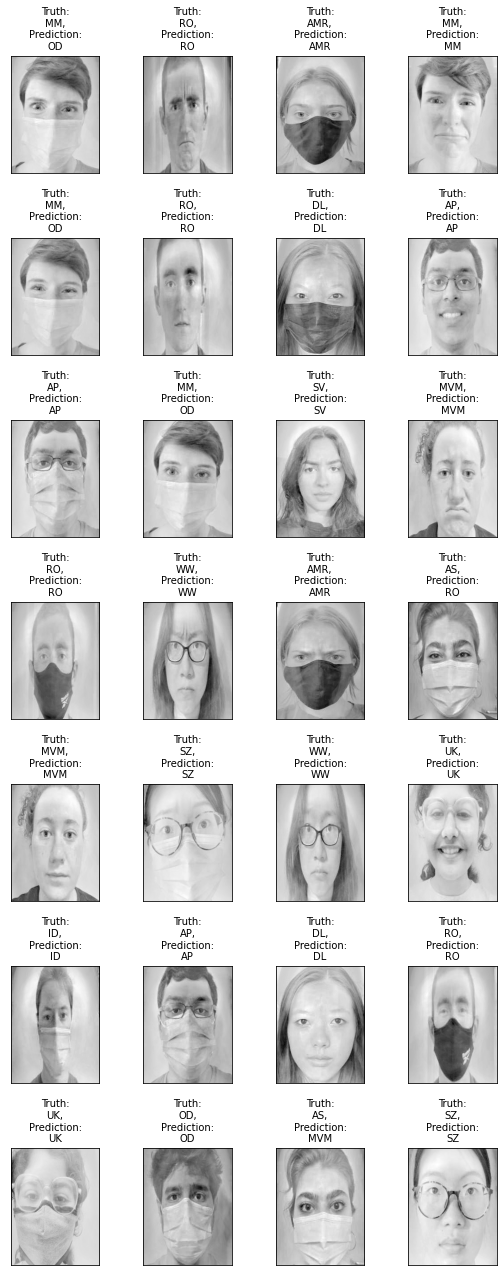

In [37]:
titles = ['Truth: %s, Prediction: %s' % (y_test_, predictions_) for y_test_, predictions_ in zip(y_test, predictions)]

plot_gallery(X_test, titles, h, w, n_samples=X_test.shape[0]-1)

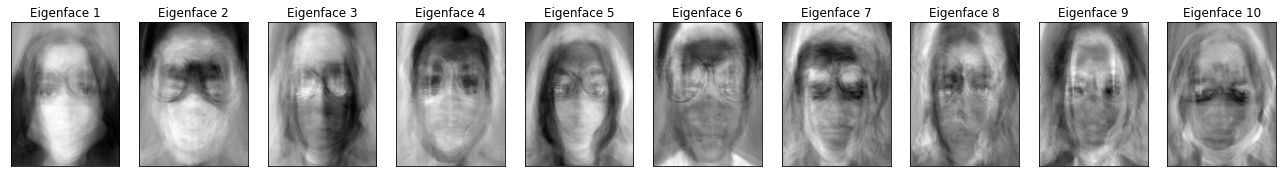

In [38]:
i=0
n_row = 1
n_col = len(eigenfaces)
plt.figure(figsize =(1.8 * n_col, 2.4 * n_row))
for eigenface in eigenfaces:
    plt.subplot(n_row, n_col, i+1)
    plt.imshow(eigenface.reshape((h,w)), cmap = plt.cm.gray)
    plt.title('Eigenface %s' % str(i+1))
    plt.xticks(()); plt.yticks(())
    i +=1

plt.tight_layout()

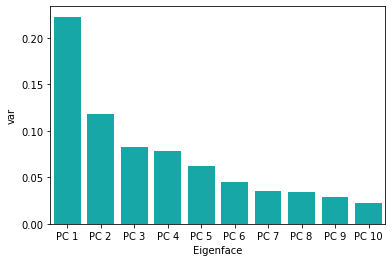

In [39]:
df = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'Eigenface': ['PC ' + str(i+1) for i in range(0, len(eigenfaces))]})

sns.barplot(x='Eigenface',y="var", data=df, color="c");

In [40]:
pc_df = pd.DataFrame(data = X_test_pca , 
        columns = ['Eigen ' + str(i+1) for i in range(0, len(eigenfaces))])
pc_df['Cluster'] = y
pc_df.head()

Eigen 1   Eigen 2   Eigen 3   Eigen 4   Eigen 5   Eigen 6   Eigen 7  \
0 -0.197991  0.731565 -0.086839  1.982642 -0.850635 -0.055291  1.036912   
1 -0.572764  0.494470 -0.576118 -1.034159  0.343038 -1.458610  0.337116   
2 -0.820833 -1.839789  1.660372 -1.297842 -0.775297  0.204702  0.755087   
3 -0.340118  0.450102 -1.037790  1.311259 -0.451085  0.012123 -0.594862   
4 -0.196241  0.522302 -0.184061  1.814351 -0.649043 -0.269577  1.294386   

    Eigen 8   Eigen 9  Eigen 10 Cluster  
0 -0.783206  0.251409 -0.514542     AMR  
1  0.655473 -0.054245 -1.030108     AMR  
2 -0.062662 -0.010400  1.549128     AMR  
3 -0.071733  0.338202 -0.897045     AMR  
4 -0.818365 -0.110422 -0.573474     AMR

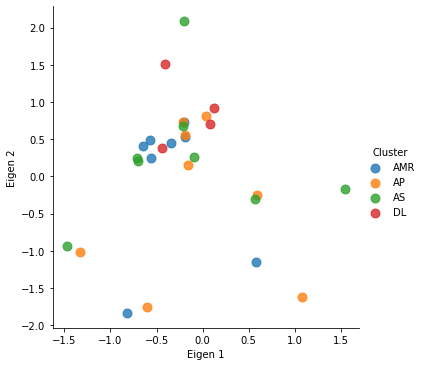

In [41]:
sns.lmplot( x="Eigen 1", y="Eigen 2",
  data=pc_df, 
  fit_reg=False, 
  hue='Cluster', # color by cluster
  legend=True,
  scatter_kws={"s": 80}) # specify the point size

In [42]:
results = results.append({'subtask': 'person', 
                          'method': '1-raw', 
                          'silhouette_score': metrics.silhouette_score(X_train, y_train)}, ignore_index=True)

print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_train, y_train))

Silhouette Coefficient: 0.180


# Method 2: Edges <a id='method2'></a>

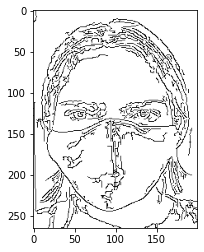

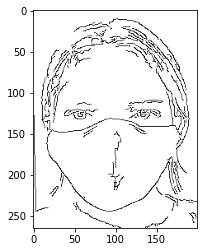

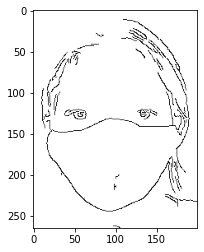

In [43]:
lower = [10, 30, 50]
upper = [50, 70, 100]

for l, u in zip(lower, upper):
    gray_image = cv2.imread(img_files[0], cv2.IMREAD_GRAYSCALE)
    edged_image = cv2.Canny(gray_image, threshold1=l, threshold2=u)
    plt.imshow(edged_image, cmap = 'Greys')
    plt.show()

In [44]:
edged_images = np.zeros((265,200))

for img_file in img_files:
    gray_image = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
    edged_image = cv2.Canny(gray_image, threshold1=30, threshold2=70)
    edged_images = np.dstack((edged_images, edged_image))

edged_images = edged_images[:,:,1:]
edged_images = np.transpose(edged_images, (2, 0, 1))
n_samples, h, w = edged_images.shape
print(edged_images.shape)                

(112, 265, 200)


In [45]:
X = edged_images.reshape((112,-1))
n_features = X.shape[1]

In [46]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X = scaler.fit_transform(X)

## Subtask 1. Emotion recognition

In [47]:
y = data['emotion']
target_names = np.unique(y)
n_classes = target_names.shape[0]

# Print Details about dataset
print("Number of Data Samples: % d" % n_samples)
print("Size of a data sample: % d" % n_features)
print("Number of Class Labels: % d" % n_classes)


Number of Data Samples:  112
Size of a data sample:  53000
Number of Class Labels:  4


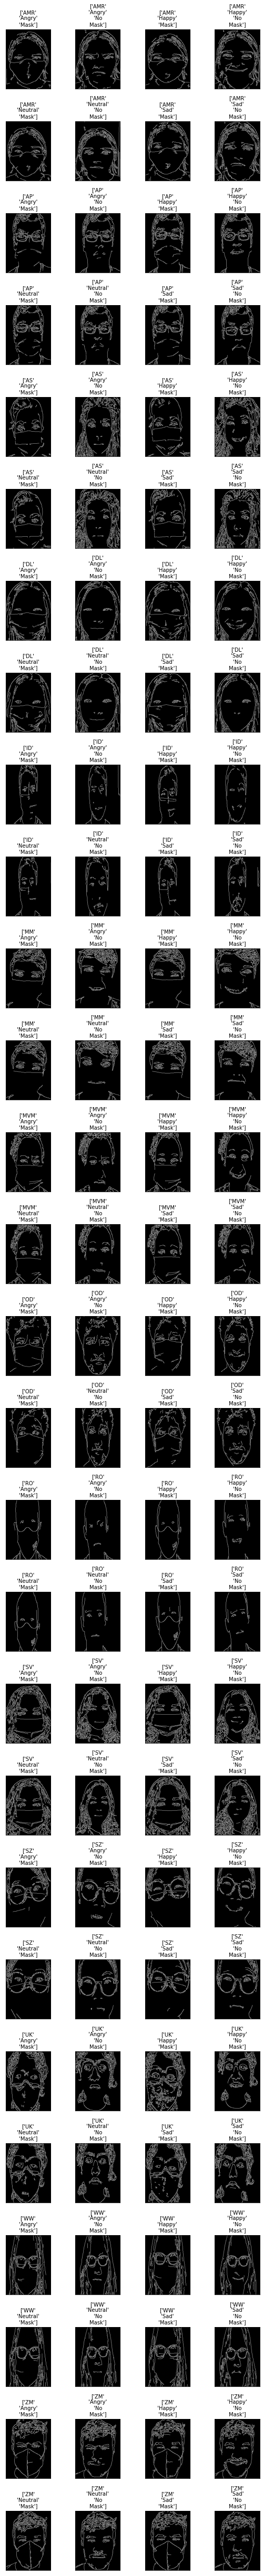

In [48]:
titles = np.array(data)
plot_gallery(X, titles, h, w)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

print("size of training Data is % d and Testing Data is % d" %(y_train.shape[0], y_test.shape[0]))



size of training Data is  84 and Testing Data is  28


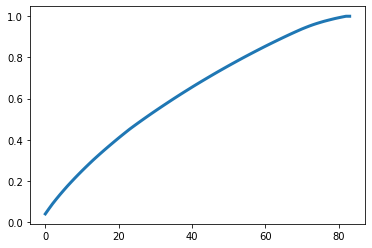

In [50]:
pca = PCA().fit(X_train)

plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3)

In [51]:
# n_components = np.where([pca.explained_variance_ratio_.cumsum() > .80])[1][0]
n_components = 10
print('Number of components: %s' % n_components)

pca = PCA(n_components = n_components, svd_solver ='randomized', whiten = True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


Number of components: 10
Projecting the input data on the eigenfaces orthonormal basis


In [52]:
classifer = SVC().fit(X_train_pca, y_train)

predictions = classifer.predict(X_test_pca)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       Angry       0.13      0.50      0.21         6
       Happy       0.00      0.00      0.00         8
     Neutral       0.00      0.00      0.00         8
         Sad       0.00      0.00      0.00         6

    accuracy                           0.11        28
   macro avg       0.03      0.12      0.05        28
weighted avg       0.03      0.11      0.04        28



In [53]:
predictions

array(['Angry', 'Angry', 'Angry', 'Angry', 'Angry', 'Angry', 'Angry',
       'Angry', 'Angry', 'Angry', 'Happy', 'Angry', 'Angry', 'Happy',
       'Angry', 'Angry', 'Angry', 'Sad', 'Happy', 'Angry', 'Angry',
       'Angry', 'Angry', 'Angry', 'Angry', 'Angry', 'Angry', 'Sad'],
      dtype=object)

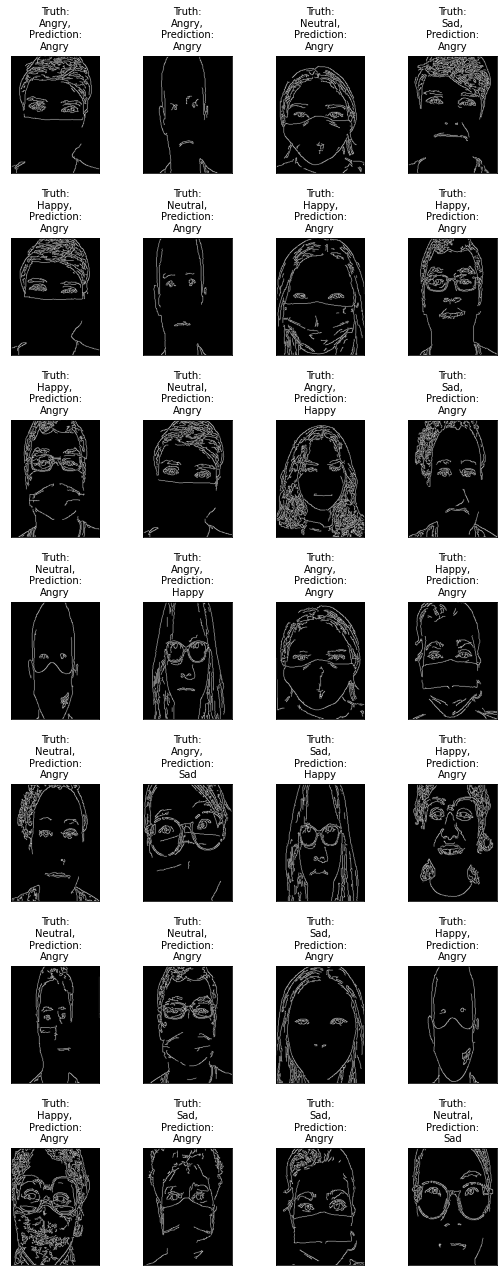

In [54]:
titles = ['Truth: %s, Prediction: %s' % (y_test_, predictions_) for y_test_, predictions_ in zip(y_test, predictions)]

plot_gallery(X_test, titles, h, w, n_samples=X_test.shape[0]-1)

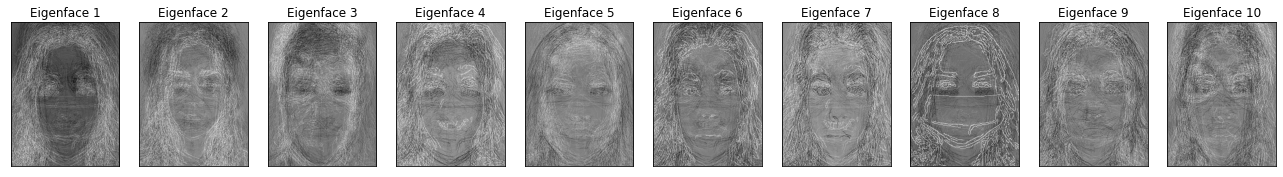

In [55]:
i=0
n_row = 1
n_col = len(eigenfaces)
plt.figure(figsize =(1.8 * n_col, 2.4 * n_row))
for eigenface in eigenfaces:
    plt.subplot(n_row, n_col, i+1)
    plt.imshow(eigenface.reshape((h,w)), cmap = plt.cm.gray)
    plt.title('Eigenface %s' % str(i+1))
    plt.xticks(()); plt.yticks(())
    i +=1

plt.tight_layout()

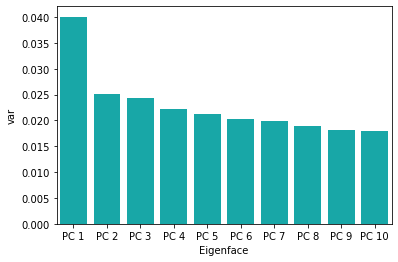

In [56]:
df = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'Eigenface': ['PC ' + str(i+1) for i in range(0, len(eigenfaces))]})

sns.barplot(x='Eigenface',y="var", data=df, color="c");

In [57]:
pc_df = pd.DataFrame(data = X_test_pca , 
        columns = ['Eigen ' + str(i+1) for i in range(0, len(eigenfaces))])
pc_df['Cluster'] = y
pc_df.head()

Eigen 1   Eigen 2   Eigen 3   Eigen 4   Eigen 5   Eigen 6   Eigen 7  \
0 -0.286957 -0.591550 -0.334051 -0.072986  0.222222 -0.298582 -0.187097   
1 -0.787908  0.613349 -0.149192  0.269794 -0.322014  0.054705  0.057594   
2  0.042919  0.322699 -0.110774 -0.368867  0.035600  0.281151  0.295182   
3 -0.294752 -0.931927 -0.253836 -0.022147  0.449780 -0.293365  0.013303   
4 -0.236090 -0.531207 -0.442337 -0.103676  0.315825 -0.317854 -0.110474   

    Eigen 8   Eigen 9  Eigen 10  Cluster  
0  0.236927  0.181102 -0.239816    Angry  
1 -0.095863  0.015595  0.202129    Angry  
2 -0.023891 -0.189198 -0.006334    Happy  
3  0.237736  0.293725 -0.061527    Happy  
4  0.267724  0.198505 -0.208312  Neutral

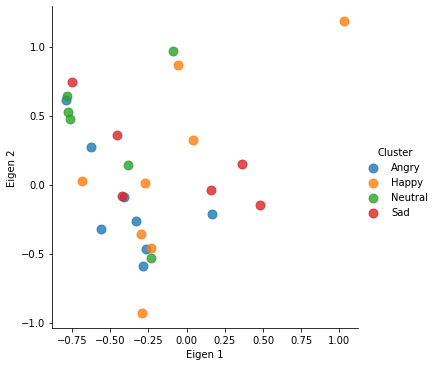

In [58]:
sns.lmplot( x="Eigen 1", y="Eigen 2",
  data=pc_df, 
  fit_reg=False, 
  hue='Cluster', # color by cluster
  legend=True,
  scatter_kws={"s": 80}) # specify the point size

In [59]:
results = results.append({'subtask': 'emotion', 
                          'method': '2-edges', 
                          'silhouette_score': metrics.silhouette_score(X_train, y_train)}, ignore_index=True)

print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_train, y_train))

Silhouette Coefficient: -0.010


## Subtask 2. Mask recognition

In [60]:
y = data['mask']
target_names = np.unique(y)
n_classes = target_names.shape[0]

# Print Details about dataset
print("Number of Data Samples: % d" % n_samples)
print("Size of a data sample: % d" % n_features)
print("Number of Class Labels: % d" % n_classes)


Number of Data Samples:  112
Size of a data sample:  53000
Number of Class Labels:  2


In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

print("size of training Data is % d and Testing Data is % d" %(y_train.shape[0], y_test.shape[0]))



size of training Data is  84 and Testing Data is  28


In [62]:
pca = PCA().fit(X_train)

In [63]:
# n_components = np.where([pca.explained_variance_ratio_.cumsum() > .80])[1][0]
n_components = 10
print('Number of components: %s' % n_components)

pca = PCA(n_components = n_components, svd_solver ='randomized', whiten = True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


Number of components: 10
Projecting the input data on the eigenfaces orthonormal basis


In [64]:
classifer = SVC().fit(X_train_pca, y_train)

predictions = classifer.predict(X_test_pca)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

        Mask       0.64      0.56      0.60        16
     No Mask       0.50      0.58      0.54        12

    accuracy                           0.57        28
   macro avg       0.57      0.57      0.57        28
weighted avg       0.58      0.57      0.57        28



In [65]:
predictions

array(['Mask', 'No Mask', 'No Mask', 'No Mask', 'Mask', 'No Mask', 'Mask',
       'Mask', 'Mask', 'Mask', 'No Mask', 'Mask', 'No Mask', 'Mask',
       'No Mask', 'Mask', 'Mask', 'No Mask', 'Mask', 'No Mask', 'No Mask',
       'Mask', 'No Mask', 'No Mask', 'Mask', 'No Mask', 'Mask', 'No Mask'],
      dtype=object)

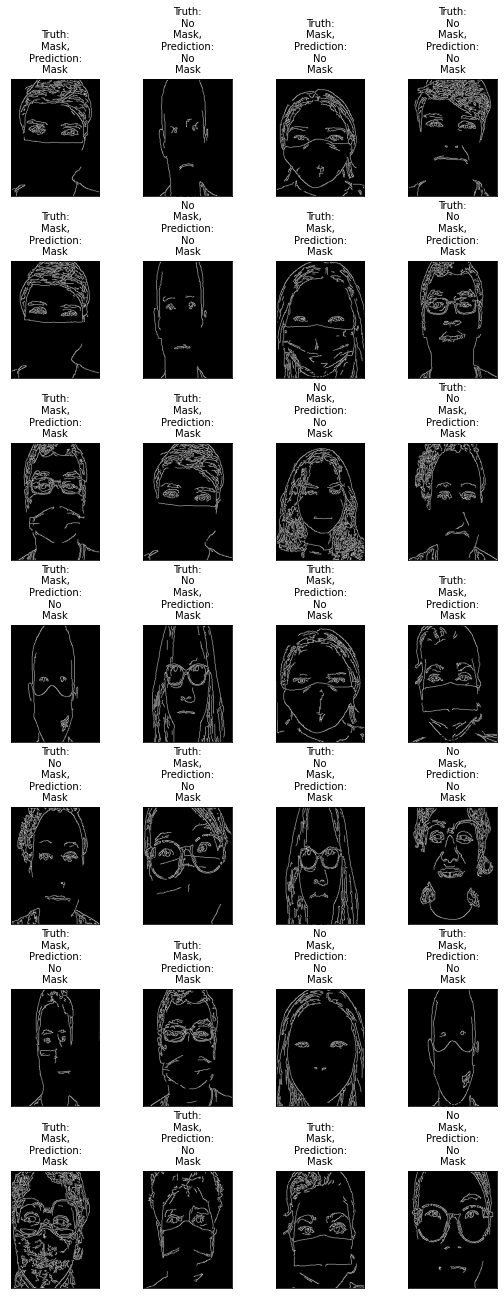

In [66]:
titles = ['Truth: %s, Prediction: %s' % (y_test_, predictions_) for y_test_, predictions_ in zip(y_test, predictions)]

plot_gallery(X_test, titles, h, w, n_samples=X_test.shape[0]-1)

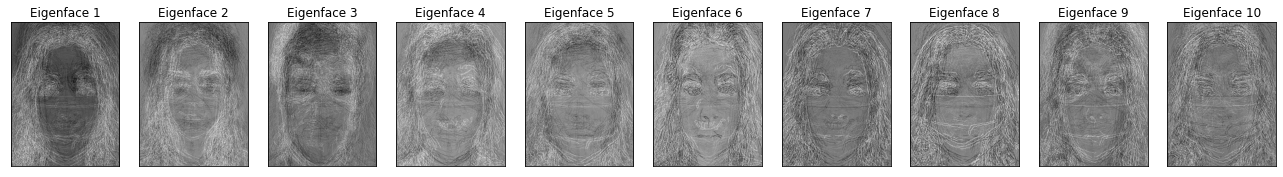

In [67]:
i=0
n_row = 1
n_col = len(eigenfaces)
plt.figure(figsize =(1.8 * n_col, 2.4 * n_row))
for eigenface in eigenfaces:
    plt.subplot(n_row, n_col, i+1)
    plt.imshow(eigenface.reshape((h,w)), cmap = plt.cm.gray)
    plt.title('Eigenface %s' % str(i+1))
    plt.xticks(()); plt.yticks(())
    i +=1

plt.tight_layout()

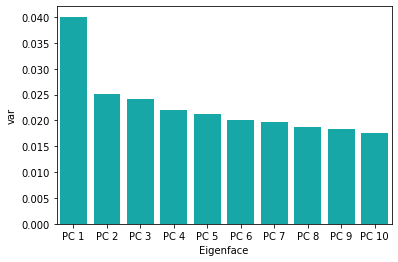

In [68]:
df = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'Eigenface': ['PC ' + str(i+1) for i in range(0, len(eigenfaces))]})

sns.barplot(x='Eigenface',y="var", data=df, color="c");

In [69]:
pc_df = pd.DataFrame(data = X_test_pca , 
        columns = ['Eigen ' + str(i+1) for i in range(0, len(eigenfaces))])
pc_df['Cluster'] = y
pc_df.head()

Eigen 1   Eigen 2   Eigen 3   Eigen 4   Eigen 5   Eigen 6   Eigen 7  \
0 -0.283253 -0.625224 -0.367411 -0.049313 -0.040926 -0.229147 -0.150691   
1 -0.790044  0.616100 -0.141941  0.286232  0.209675  0.135417  0.132962   
2  0.037870  0.342807 -0.037192 -0.516040 -0.148312  0.304979  0.056046   
3 -0.289545 -0.979504 -0.303983 -0.028144 -0.253173 -0.065332 -0.147261   
4 -0.232104 -0.578118 -0.493999 -0.097225 -0.052939 -0.135837 -0.170784   

    Eigen 8   Eigen 9  Eigen 10  Cluster  
0  0.214950 -0.197886  0.112433     Mask  
1 -0.114905  0.145601 -0.082660  No Mask  
2  0.021435 -0.042296 -0.054900     Mask  
3  0.163846 -0.050839  0.103850  No Mask  
4  0.159291 -0.236252  0.131162     Mask

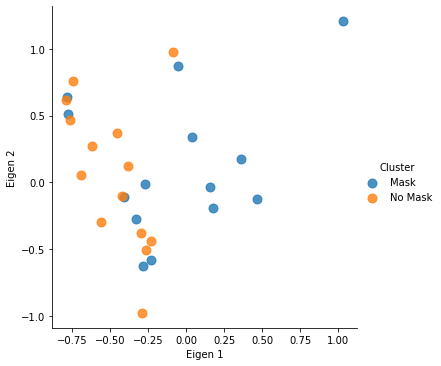

In [70]:
sns.lmplot( x="Eigen 1", y="Eigen 2",
  data=pc_df, 
  fit_reg=False, 
  hue='Cluster', # color by cluster
  legend=True,
  scatter_kws={"s": 80}) # specify the point size

In [71]:
results = results.append({'subtask': 'mask', 
                          'method': '2-edges', 
                          'silhouette_score': metrics.silhouette_score(X_train, y_train)}, ignore_index=True)

print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_train, y_train))

Silhouette Coefficient: 0.000


## Subtask 3. Person recognition

In [72]:
y = data['person']
target_names = np.unique(y)
n_classes = target_names.shape[0]

# Print Details about dataset
print("Number of Data Samples: % d" % n_samples)
print("Size of a data sample: % d" % n_features)
print("Number of Class Labels: % d" % n_classes)


Number of Data Samples:  112
Size of a data sample:  53000
Number of Class Labels:  14


In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

print("size of training Data is % d and Testing Data is % d" %(y_train.shape[0], y_test.shape[0]))



size of training Data is  84 and Testing Data is  28


In [74]:
pca = PCA().fit(X_train)

In [75]:
n_components = 10
print('Number of components: %s' % n_components)

pca = PCA(n_components = n_components, svd_solver ='randomized', whiten = True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


Number of components: 10
Projecting the input data on the eigenfaces orthonormal basis


In [76]:
classifer = SVC().fit(X_train_pca, y_train)

predictions = classifer.predict(X_test_pca)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         AMR       0.33      0.50      0.40         2
          AP       0.00      0.00      0.00         3
          AS       0.00      0.00      0.00         2
          DL       0.00      0.00      0.00         2
          ID       0.12      1.00      0.22         1
          MM       1.00      0.25      0.40         4
         MVM       0.25      1.00      0.40         2
          OD       0.33      1.00      0.50         1
          RO       0.00      0.00      0.00         4
          SV       0.00      0.00      0.00         1
          SZ       1.00      1.00      1.00         2
          UK       0.00      0.00      0.00         2
          WW       0.67      1.00      0.80         2

    accuracy                           0.36        28
   macro avg       0.29      0.44      0.29        28
weighted avg       0.32      0.36      0.27        28



In [77]:
predictions

array(['MVM', 'ID', 'ID', 'MM', 'MVM', 'ID', 'AMR', 'MVM', 'MVM', 'MVM',
       'WW', 'MVM', 'ID', 'WW', 'AMR', 'ID', 'MVM', 'SZ', 'WW', 'OD',
       'ID', 'MVM', 'AMR', 'ID', 'OD', 'OD', 'ID', 'SZ'], dtype=object)

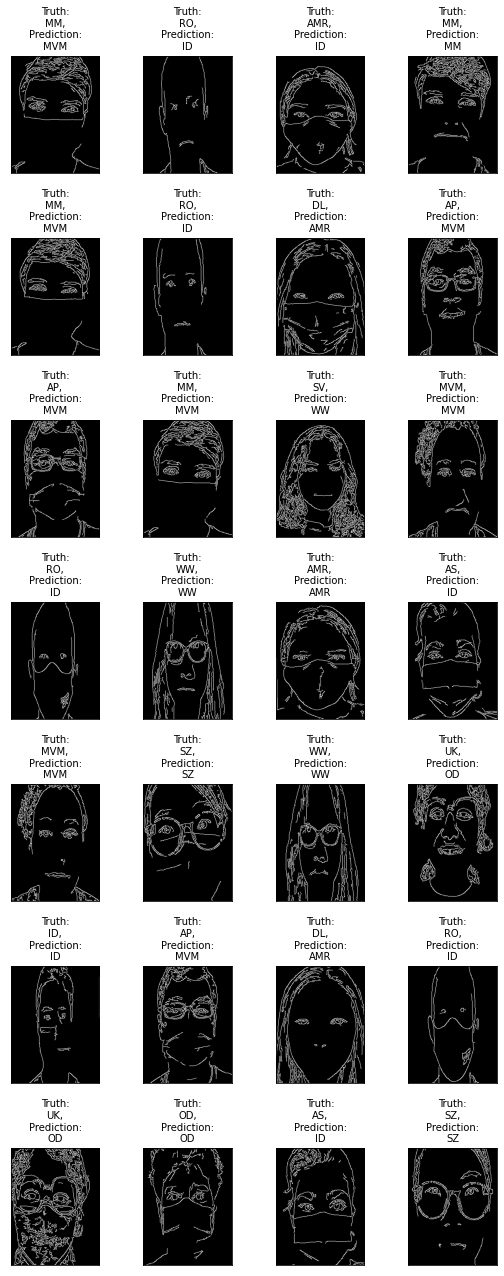

In [78]:
titles = ['Truth: %s, Prediction: %s' % (y_test_, predictions_) for y_test_, predictions_ in zip(y_test, predictions)]

plot_gallery(X_test, titles, h, w, n_samples=X_test.shape[0]-1)
plt.savefig('edgefaces.png')

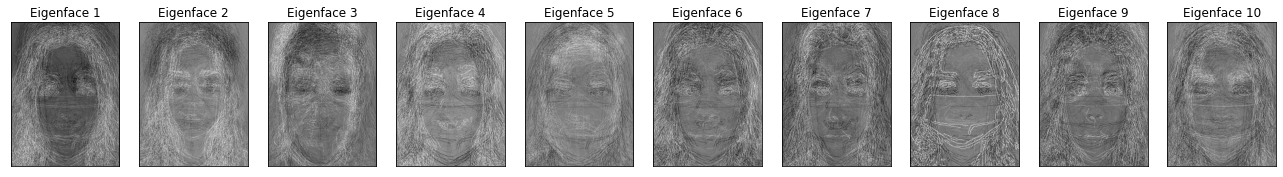

In [79]:
i=0
n_row = 1
n_col = len(eigenfaces)
plt.figure(figsize =(1.8 * n_col, 2.4 * n_row))
for eigenface in eigenfaces:
    plt.subplot(n_row, n_col, i+1)
    plt.imshow(eigenface.reshape((h,w)), cmap = plt.cm.gray)
    plt.title('Eigenface %s' % str(i+1))
    plt.xticks(()); plt.yticks(())
    i +=1

plt.tight_layout()

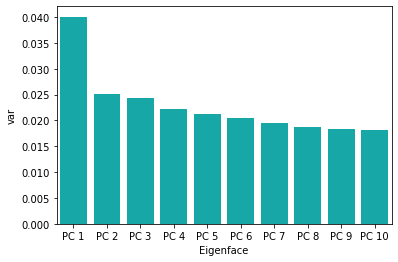

In [80]:
df = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'Eigenface': ['PC ' + str(i+1) for i in range(0, len(eigenfaces))]})

sns.barplot(x='Eigenface',y="var", data=df, color="c");

In [131]:
pc_df = pd.DataFrame(data = X_test_pca , 
        columns = ['Eigen ' + str(i+1) for i in range(0, len(eigenfaces))])
pc_df['Cluster'] = y
pc_df.head()

Eigen 1   Eigen 2   Eigen 3 Cluster
0 -0.391984  0.676349 -1.700764     AMR
1 -0.071266 -1.552942  0.851833     AMR
2 -0.230546 -1.002468 -1.029674     AMR
3  0.206416  1.854614  0.035905     AMR
4 -0.632614  0.316645 -0.082731     AMR

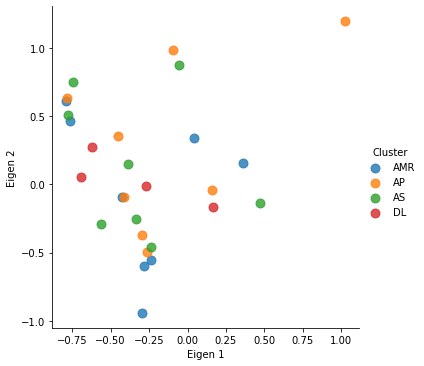

In [82]:
sns.lmplot( x="Eigen 1", y="Eigen 2",
  data=pc_df, 
  fit_reg=False, 
  hue='Cluster', # color by cluster
  legend=True,
  scatter_kws={"s": 80}) # specify the point size

In [83]:
results = results.append({'subtask': 'person', 
                          'method': '2-edges', 
                          'silhouette_score': metrics.silhouette_score(X_train, y_train)}, ignore_index=True)

print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_train, y_train))

Silhouette Coefficient: -0.110


In [84]:
results.sort_values('subtask')

subtask   method  silhouette_score
0  emotion    1-raw         -0.036860
3  emotion  2-edges         -0.010019
1     mask    1-raw          0.005638
4     mask  2-edges          0.000223
2   person    1-raw          0.179526
5   person  2-edges         -0.109766

# Method 3: Crop <a id='method3'></a>

In [85]:
math.ceil(img0.shape[1]/2)

100

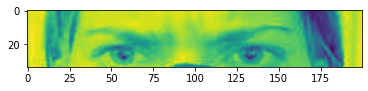

In [86]:
plt.imshow(img0[math.ceil(img0.shape[1]*(1/2)): math.ceil(img0.shape[1]*(2/3)),:])

In [87]:
scale1 = (1/3)
scale2 = (4/5)

cropped_images = np.zeros((265,200))
cropped_images = cropped_images[math.ceil(img0.shape[1]*scale1): math.ceil(img0.shape[1]*scale2),:]

for img_file in img_files:
    gray_image = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
    cropped_image = gray_image[math.ceil(gray_image.shape[1]*scale1): math.ceil(gray_image.shape[1]*scale2),:]
    cropped_images = np.dstack((cropped_images, cropped_image))

cropped_images = cropped_images[:,:,1:]
cropped_images = np.transpose(cropped_images, (2, 0, 1))
n_samples, h, w = cropped_images.shape
print(cropped_images.shape)                

(112, 93, 200)


In [88]:
X = cropped_images.reshape((112,-1))
n_features = X.shape[1]
print(X.shape)

(112, 18600)


In [89]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X = scaler.fit_transform(X)

## Subtask 1. Emotion recognition

In [90]:
y = data['emotion']
target_names = np.unique(y)
n_classes = target_names.shape[0]

# Print Details about dataset
print("Number of Data Samples: % d" % n_samples)
print("Size of a data sample: % d" % n_features)
print("Number of Class Labels: % d" % n_classes)


Number of Data Samples:  112
Size of a data sample:  18600
Number of Class Labels:  4


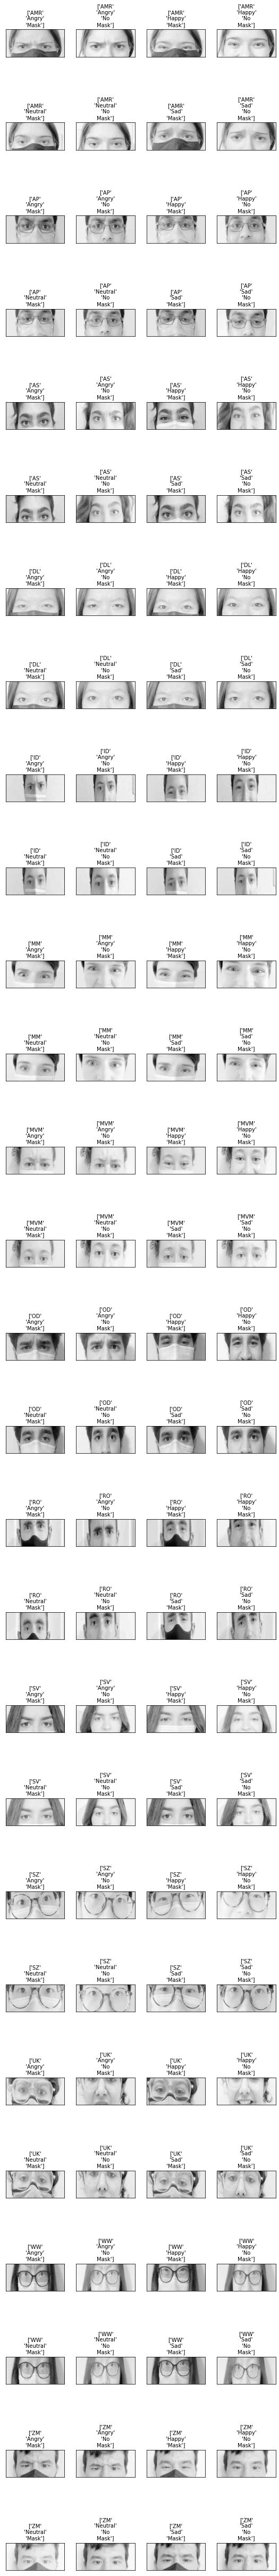

In [91]:
titles = np.array(data)
plot_gallery(X, titles, h, w)
plt.savefig('crop.png')

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

print("size of training Data is % d and Testing Data is % d" %(y_train.shape[0], y_test.shape[0]))



size of training Data is  84 and Testing Data is  28


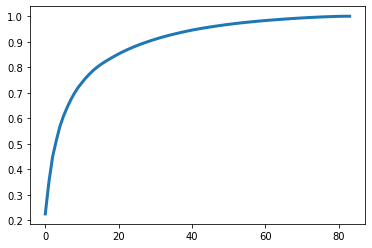

In [93]:
pca = PCA().fit(X_train)

plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3)

In [94]:
# n_components = np.where([pca.explained_variance_ratio_.cumsum() > .80])[1][0]
n_components = 10
print('Number of components: %s' % n_components)

pca = PCA(n_components = n_components, svd_solver ='randomized', whiten = True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


Number of components: 10
Projecting the input data on the eigenfaces orthonormal basis


In [95]:
classifer = SVC().fit(X_train_pca, y_train)

predictions = classifer.predict(X_test_pca)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       Angry       0.08      0.17      0.11         6
       Happy       0.00      0.00      0.00         8
     Neutral       0.00      0.00      0.00         8
         Sad       0.00      0.00      0.00         6

    accuracy                           0.04        28
   macro avg       0.02      0.04      0.03        28
weighted avg       0.02      0.04      0.02        28



In [96]:
predictions

array(['Sad', 'Angry', 'Sad', 'Angry', 'Sad', 'Happy', 'Angry', 'Sad',
       'Angry', 'Angry', 'Neutral', 'Angry', 'Angry', 'Neutral', 'Sad',
       'Angry', 'Happy', 'Sad', 'Neutral', 'Angry', 'Sad', 'Sad', 'Angry',
       'Sad', 'Neutral', 'Angry', 'Angry', 'Sad'], dtype=object)

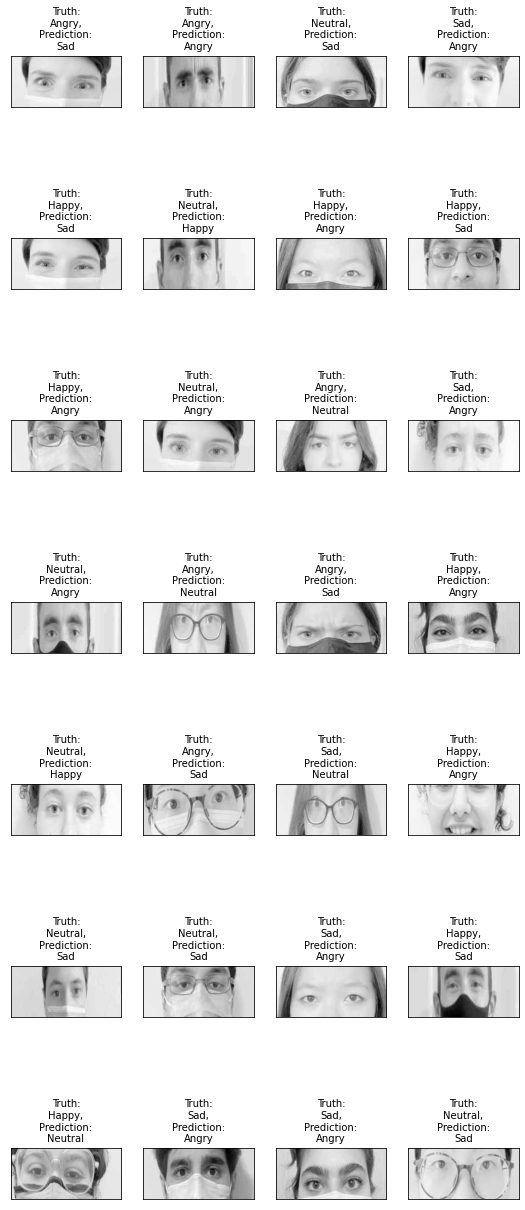

In [97]:
titles = ['Truth: %s, Prediction: %s' % (y_test_, predictions_) for y_test_, predictions_ in zip(y_test, predictions)]

plot_gallery(X_test, titles, h, w, n_samples=X_test.shape[0]-1)

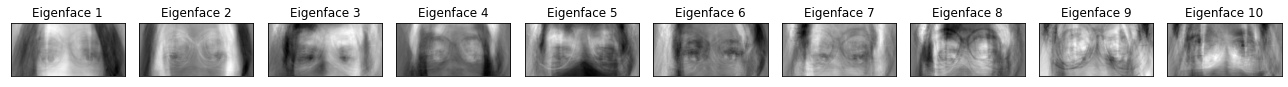

In [98]:
i=0
n_row = 1
n_col = len(eigenfaces)
plt.figure(figsize =(1.8 * n_col, 2.4 * n_row))
for eigenface in eigenfaces:
    plt.subplot(n_row, n_col, i+1)
    plt.imshow(eigenface.reshape((h,w)), cmap = plt.cm.gray)
    plt.title('Eigenface %s' % str(i+1))
    plt.xticks(()); plt.yticks(())
    i +=1

plt.tight_layout()

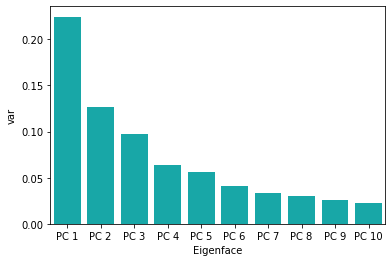

In [99]:
df = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'Eigenface': ['PC ' + str(i+1) for i in range(0, len(eigenfaces))]})

sns.barplot(x='Eigenface',y="var", data=df, color="c");

In [100]:
pc_df = pd.DataFrame(data = X_test_pca , 
        columns = ['Eigen ' + str(i+1) for i in range(0, len(eigenfaces))])
pc_df['Cluster'] = y
pc_df.head()

Eigen 1   Eigen 2   Eigen 3   Eigen 4   Eigen 5   Eigen 6   Eigen 7  \
0  0.385322 -0.338304 -1.200858 -1.586162  0.820819 -1.266392 -0.212626   
1 -1.230931  0.566654  0.118321  1.000820 -0.541622  0.744427  0.785441   
2  0.083187 -0.125621 -0.321582  1.286019  2.195852 -1.609676  0.053200   
3 -0.377919  0.227250 -0.358685 -1.323475 -0.593307 -0.785085 -0.917874   
4  0.335141 -0.521504 -1.013750 -1.402277  0.857109 -1.517282  0.512403   

    Eigen 8   Eigen 9  Eigen 10  Cluster  
0 -2.368957 -0.228917 -0.208567    Angry  
1 -0.178019 -0.526434  0.344500    Angry  
2 -0.974805 -0.467905 -0.339468    Happy  
3 -1.203242 -0.481610  0.890887    Happy  
4 -1.958520 -0.523617 -0.071902  Neutral

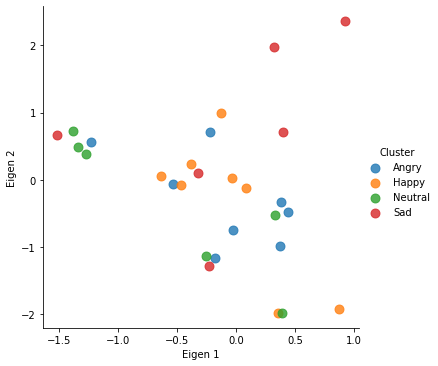

In [101]:
sns.lmplot( x="Eigen 1", y="Eigen 2",
  data=pc_df, 
  fit_reg=False, 
  hue='Cluster', # color by cluster
  legend=True,
  scatter_kws={"s": 80}) # specify the point size

In [102]:
results = results.append({'subtask': 'emotion', 
                          'method': '3-crop', 
                          'silhouette_score': metrics.silhouette_score(X_train, y_train)}, ignore_index=True)

print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_train, y_train))

Silhouette Coefficient: -0.032


## Subtask 2. Mask recognition

In [103]:
y = data['mask']
target_names = np.unique(y)
n_classes = target_names.shape[0]

# Print Details about dataset
print("Number of Data Samples: % d" % n_samples)
print("Size of a data sample: % d" % n_features)
print("Number of Class Labels: % d" % n_classes)


Number of Data Samples:  112
Size of a data sample:  18600
Number of Class Labels:  2


In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

print("size of training Data is % d and Testing Data is % d" %(y_train.shape[0], y_test.shape[0]))



size of training Data is  84 and Testing Data is  28


In [105]:
pca = PCA().fit(X_train)

In [106]:
# n_components = np.where([pca.explained_variance_ratio_.cumsum() > .80])[1][0]
n_components = 10
print('Number of components: %s' % n_components)

pca = PCA(n_components = n_components, svd_solver ='randomized', whiten = True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


Number of components: 10
Projecting the input data on the eigenfaces orthonormal basis


In [107]:
classifer = SVC().fit(X_train_pca, y_train)

predictions = classifer.predict(X_test_pca)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

        Mask       0.90      0.56      0.69        16
     No Mask       0.61      0.92      0.73        12

    accuracy                           0.71        28
   macro avg       0.76      0.74      0.71        28
weighted avg       0.78      0.71      0.71        28



In [108]:
predictions

array(['Mask', 'No Mask', 'Mask', 'No Mask', 'Mask', 'No Mask', 'Mask',
       'No Mask', 'No Mask', 'Mask', 'No Mask', 'No Mask', 'No Mask',
       'No Mask', 'Mask', 'No Mask', 'No Mask', 'No Mask', 'No Mask',
       'Mask', 'No Mask', 'No Mask', 'No Mask', 'Mask', 'Mask', 'No Mask',
       'Mask', 'No Mask'], dtype=object)

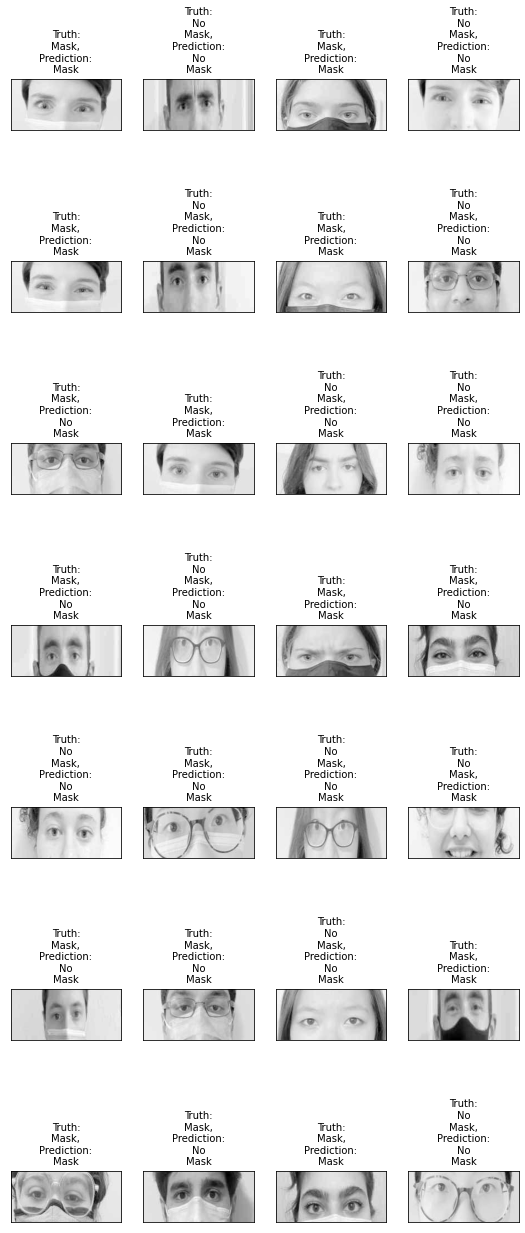

In [109]:
titles = ['Truth: %s, Prediction: %s' % (y_test_, predictions_) for y_test_, predictions_ in zip(y_test, predictions)]

plot_gallery(X_test, titles, h, w, n_samples=X_test.shape[0]-1)

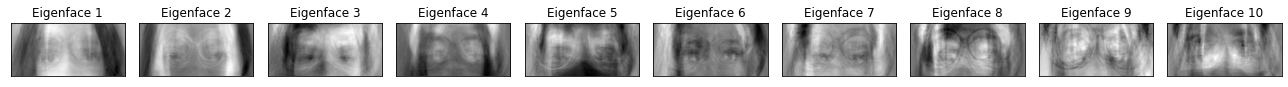

In [110]:
i=0
n_row = 1
n_col = len(eigenfaces)
plt.figure(figsize =(1.8 * n_col, 2.4 * n_row))
for eigenface in eigenfaces:
    plt.subplot(n_row, n_col, i+1)
    plt.imshow(eigenface.reshape((h,w)), cmap = plt.cm.gray)
    plt.title('Eigenface %s' % str(i+1))
    plt.xticks(()); plt.yticks(())
    i +=1

plt.tight_layout()

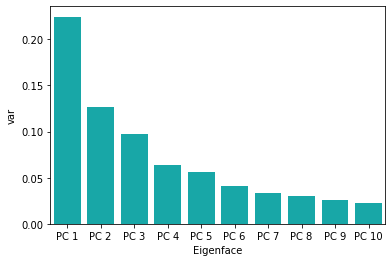

In [111]:
df = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'Eigenface': ['PC ' + str(i+1) for i in range(0, len(eigenfaces))]})

sns.barplot(x='Eigenface',y="var", data=df, color="c");

In [112]:
pc_df = pd.DataFrame(data = X_test_pca , 
        columns = ['Eigen ' + str(i+1) for i in range(0, len(eigenfaces))])
pc_df['Cluster'] = y
pc_df.head()

Eigen 1   Eigen 2   Eigen 3   Eigen 4   Eigen 5   Eigen 6   Eigen 7  \
0  0.385322 -0.338305 -1.200853 -1.586160  0.820759 -1.266537 -0.213598   
1 -1.230931  0.566653  0.118321  1.000809 -0.541597  0.744437  0.785017   
2  0.083187 -0.125622 -0.321584  1.285993  2.195882 -1.609694  0.052296   
3 -0.377919  0.227252 -0.358680 -1.323425 -0.593354 -0.785045 -0.917994   
4  0.335141 -0.521504 -1.013746 -1.402272  0.857041 -1.517448  0.512032   

    Eigen 8   Eigen 9  Eigen 10  Cluster  
0 -2.366635 -0.230612 -0.216356     Mask  
1 -0.177699 -0.527329  0.341926  No Mask  
2 -0.974607 -0.472890 -0.333693     Mask  
3 -1.201882 -0.478518  0.883813  No Mask  
4 -1.956675 -0.525377 -0.081825     Mask

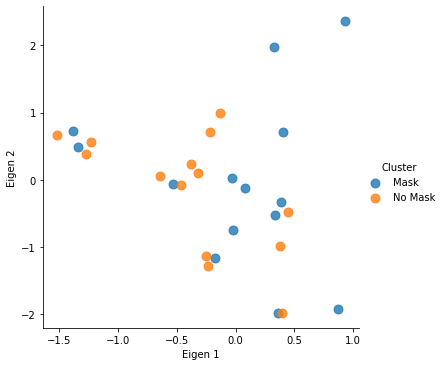

In [113]:
sns.lmplot( x="Eigen 1", y="Eigen 2",
  data=pc_df, 
  fit_reg=False, 
  hue='Cluster', # color by cluster
  legend=True,
  scatter_kws={"s": 80}) # specify the point size

In [114]:
results = results.append({'subtask': 'mask', 
                          'method': '3-crop', 
                          'silhouette_score': metrics.silhouette_score(X_train, y_train)}, ignore_index=True)

print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_train, y_train))

Silhouette Coefficient: 0.001


## Subtask 3. Person recognition

In [115]:
y = data['person']
target_names = np.unique(y)
n_classes = target_names.shape[0]

# Print Details about dataset
print("Number of Data Samples: % d" % n_samples)
print("Size of a data sample: % d" % n_features)
print("Number of Class Labels: % d" % n_classes)


Number of Data Samples:  112
Size of a data sample:  18600
Number of Class Labels:  14


In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

print("size of training Data is % d and Testing Data is % d" %(y_train.shape[0], y_test.shape[0]))



size of training Data is  84 and Testing Data is  28


In [117]:
pca = PCA().fit(X_train)

In [118]:
n_components = 3
print('Number of components: %s' % n_components)

pca = PCA(n_components = n_components, svd_solver ='randomized', whiten = True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


Number of components: 3
Projecting the input data on the eigenfaces orthonormal basis


In [119]:
classifer = SVC().fit(X_train_pca, y_train)

predictions = classifer.predict(X_test_pca)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         AMR       1.00      0.50      0.67         2
          AP       1.00      1.00      1.00         3
          AS       0.00      0.00      0.00         2
          DL       1.00      1.00      1.00         2
          ID       0.20      1.00      0.33         1
          MM       0.00      0.00      0.00         4
         MVM       0.67      1.00      0.80         2
          OD       0.20      1.00      0.33         1
          RO       0.00      0.00      0.00         4
          SV       1.00      1.00      1.00         1
          SZ       1.00      1.00      1.00         2
          UK       0.25      0.50      0.33         2
          WW       1.00      1.00      1.00         2

    accuracy                           0.57        28
   macro avg       0.56      0.69      0.57        28
weighted avg       0.51      0.57      0.51        28



In [120]:
predictions

array(['OD', 'ID', 'UK', 'UK', 'OD', 'ID', 'DL', 'AP', 'AP', 'OD', 'SV',
       'MVM', 'ID', 'WW', 'AMR', 'UK', 'MVM', 'SZ', 'WW', 'UK', 'ID',
       'AP', 'DL', 'ID', 'OD', 'OD', 'MVM', 'SZ'], dtype=object)

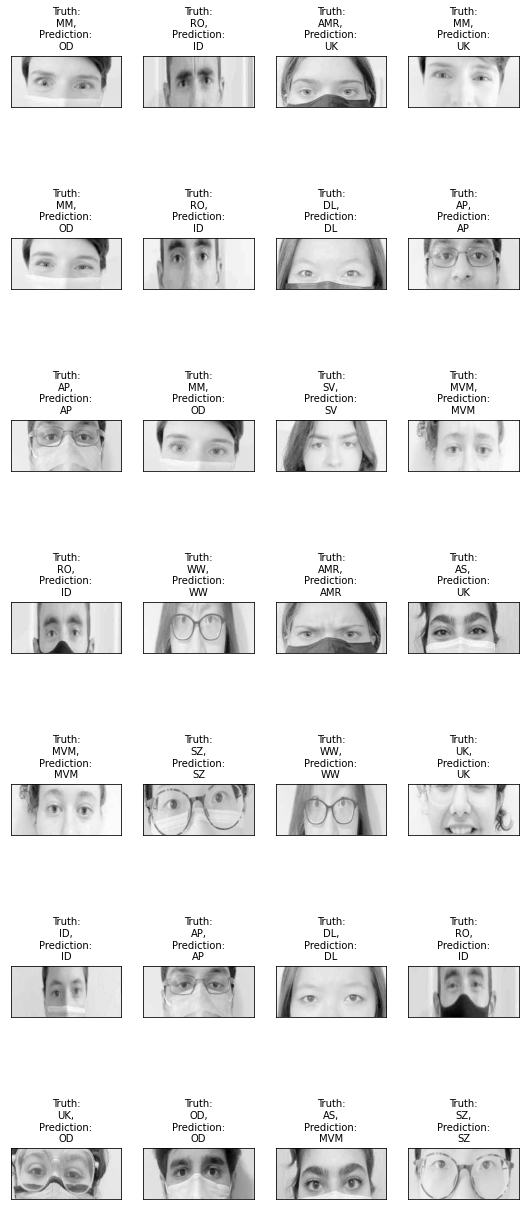

In [121]:
titles = ['Truth: %s, Prediction: %s' % (y_test_, predictions_) for y_test_, predictions_ in zip(y_test, predictions)]

plot_gallery(X_test, titles, h, w, n_samples=X_test.shape[0]-1)

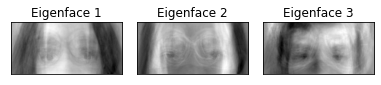

In [122]:
i=0
n_row = 1
n_col = len(eigenfaces)
plt.figure(figsize =(1.8 * n_col, 2.4 * n_row))
for eigenface in eigenfaces:
    plt.subplot(n_row, n_col, i+1)
    plt.imshow(eigenface.reshape((h,w)), cmap = plt.cm.gray)
    plt.title('Eigenface %s' % str(i+1))
    plt.xticks(()); plt.yticks(())
    i +=1

plt.tight_layout()

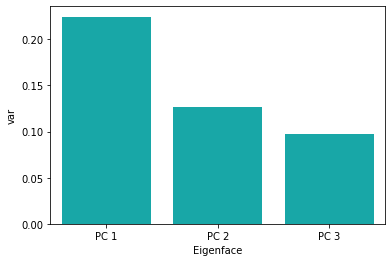

In [123]:
df = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'Eigenface': ['PC ' + str(i+1) for i in range(0, len(eigenfaces))]})

sns.barplot(x='Eigenface',y="var", data=df, color="c");

In [124]:
pc_df = pd.DataFrame(data = X_test_pca , 
        columns = ['Eigen ' + str(i+1) for i in range(0, len(eigenfaces))])
pc_df['Cluster'] = y
pc_df.head()

Eigen 1   Eigen 2   Eigen 3 Cluster
0  0.385322 -0.338303 -1.200857     AMR
1 -1.230931  0.566654  0.118321     AMR
2  0.083187 -0.125622 -0.321583     AMR
3 -0.377919  0.227252 -0.358681     AMR
4  0.335141 -0.521503 -1.013749     AMR

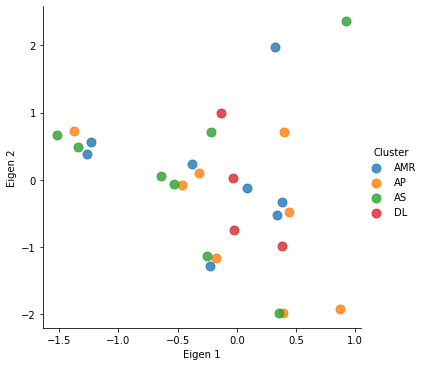

In [125]:
sns.lmplot( x="Eigen 1", y="Eigen 2",
  data=pc_df, 
  fit_reg=False, 
  hue='Cluster', # color by cluster
  legend=True,
  scatter_kws={"s": 80}) # specify the point size

In [126]:
results = results.append({'subtask': 'person', 
                          'method': '3-crop', 
                          'silhouette_score': metrics.silhouette_score(pc_df[['Eigen 1', 'Eigen 2']], pc_df['Cluster'])}, ignore_index=True)

print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(pc_df[['Eigen 1', 'Eigen 2']], pc_df['Cluster']))

Silhouette Coefficient: -0.205


In [127]:
metrics.silhouette_score(pc_df[['Eigen 1', 'Eigen 2']], pc_df['Cluster'])

-0.20498749475527694

# Report <a id='report'></a>

For this assignment, I used PCA to decompose 112 face images into 10 eigenfaces. I tried finding the optimal number of components to use to reach 80% accuracy, but decided instead that I wanted to keep the number of components the same to be able to compare each of the image preprocessing methods easier. I used the silhouette score to evaluate PCA performance after three preprocessing alternatives:

1) raw grayscale images <br>
2) image edges <br>
3) cropped images (focusing on eye to lip area) <br>

For the emotion subtask, the silhouette score was lowest when PCA was applied on the grayscale images. Cropped images yielded the second best performance, with edge images yielding the worst performance. This suggests that the algorithm was best able to make use of the full grayscale image in order to provide information about the emotion. It could be that a different edge threshold would have produced better results. Several edge thresholds were piloted, and I selected the one that I thought conveyed useful information but minimized extraneous information. It could be that the algorithm has a different idea about what constitutes useful information.


In [128]:
results[results['subtask'] == 'emotion'].sort_values(['silhouette_score'], ascending=False)

subtask   method  silhouette_score
3  emotion  2-edges         -0.010019
6  emotion   3-crop         -0.031865
0  emotion    1-raw         -0.036860

For the mask classification, the edge images yielded the best PCA performance, followed by the cropped images, followed by the raw. Because the mask is a fairly large, undetailed object, it could be that using the edges maximized the amount of information available about the mask presence over and above what the raw or cropped images provided. It was interesting to me that the cropped images performed better than the raw images here, since the majority of the mask area was removed. The remaining pixels containing mask vs. no mask data remained sufficient, and even relatively more useful, for the classification task.

In [129]:
results[results['subtask'] == 'mask'].sort_values(['silhouette_score'], ascending=False)

subtask   method  silhouette_score
1    mask    1-raw          0.005638
7    mask   3-crop          0.000991
4    mask  2-edges          0.000223

Similar results were obtained for person classification as were found for the mask classification. Again, PCA performed on the edge images yielded the best results, followed by the cropped images, followed by the raw images.

In [130]:
results[results['subtask'] == 'person'].sort_values(['silhouette_score'], ascending=False)

subtask   method  silhouette_score
2  person    1-raw          0.179526
5  person  2-edges         -0.109766
8  person   3-crop         -0.204987

In addition to using the silhouette score, I also fed the PCA results to a SVM classifier and used that to give predictive labels to images in the training dataset.

# References

[Sandipanweb Eigenfaces Tutorial](https://sandipanweb.wordpress.com/2018/01/06/eigenfaces-and-a-simple-face-detector-with-pca-svd-in-python/)